<img src="https://github.com/nicholasmetherall/digital-earth-pacific-macblue-activities/blob/main/attachments/images/DE_Pacific_banner.JPG?raw=true" width="900"/>
Figure 1.1.a. Jupyter environment + Python notebooks

### Digital Earth Pacific Notebook 1 prepare postcard and load data to csv

The objective of this notebook is to prepare a geomad postcard for your AOI (masking, scaling and loading additional band ratios and spectral indices) and sampling all the datasets into a csv based on your training data geodataframe.

Step 1.1

In [1]:
from pystac_client import Client
from dask.distributed import Client as DaskClient
from odc.stac import load, configure_s3_access
import rasterio as rio
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import folium
from datetime import datetime
import utils
from utils import scale
from utils import calculate_band_indices
from utils import load_data
from utils import patchwise_glcm_feature
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import odc.geo.xr
import rioxarray
import matplotlib.pyplot as plt
import joblib
from shapely.geometry import box
import skimage.feature
from skimage.feature import graycomatrix, graycoprops
from skimage import data
from skimage.util import view_as_windows
import dask.array as da

In [2]:
# Predefined variable for title and version

# Enter your initials
initials = "nm"
# Enter your site name
site = "bootless"
# Date
date = datetime.now()
date = date.strftime("%d-%m-%Y")

version = initials+'-'+site+'-'+date

print(version)

nm-bootless-04-07-2025


Define catalogue

In [3]:
catalog = "https://stac.digitalearthpacific.org"
client = Client.open(catalog)

In [4]:
## Use tdata bounds

gdf = gpd.read_file("training-data/bootless_bay.geojson")
gdf = gdf.to_crs("EPSG:4326")
min_lon, min_lat, max_lon, max_lat = gdf.total_bounds
bbox = [min_lon, min_lat, max_lon, max_lat]

In [5]:
## Use bounding box

# min_lon = 160.08855
# min_lat = -9.12915
# max_lon = 160.17137
# max_lat = -9.08003

# bbox = [min_lon, min_lat, max_lon, max_lat]

In [6]:
datetime="2024"
items = list(client.search(collections=["dep_s2_geomad"], datetime=datetime, bbox=bbox).items())

In [7]:
from pystac import Collection

In [8]:
collection = Collection.from_file("https://stac.digitalearthpacific.org/collections/dep_s2_geomad")

In [9]:
data = load(
        items,
        measurements=[
            "nir", "red", "blue", "green", "emad", "smad", 
            "bcmad", "count", "green", "nir08", 
            "nir09", "swir16", "swir22", "coastal",
            "rededge1", "rededge2", "rededge3", 
        ],
        bbox=bbox,
        chunks={"x": 2048, "y": 2048},
        groupby="solar_day",
    )

In [10]:
dask_client = DaskClient(n_workers=1, threads_per_worker=16, memory_limit='16GB')
configure_s3_access(cloud_defaults=True, requester_pays=True)

/srv/conda/envs/notebook/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35791 instead
  warnings.warn(


In [16]:
scaled = (data.where(data != 0) * 0.0001).clip(0, 1)

In [17]:
mndwi = (scaled["green"]-scaled["swir16"])/(scaled["green"]+scaled["swir16"])
## Moderate land mask
# mndwi_land_mask = mndwi > 0
mndwi_land_mask = mndwi > -1.5
clipped_ds = scaled.where(mndwi_land_mask)

In [18]:
ndti = (clipped_ds["red"]-clipped_ds["green"])/(clipped_ds["red"]+clipped_ds["green"])
ndti_mask = ndti < 0.2
clipped_ds = clipped_ds.where(ndti_mask)

In [19]:
nir = clipped_ds['nir']

# Moderate land mask
# nir_mask = nir < 0.085

# Conservative land mask
nir_mask = nir < 0.8
clipped_ds = clipped_ds.where(nir_mask)

In [20]:
# Incorporate other band ratios and indices
cai = (clipped_ds["coastal"]-clipped_ds["blue"])/( clipped_ds["coastal"]+ clipped_ds["blue"]) #coastal aerosol index
ndvi = (clipped_ds["nir"]-clipped_ds["red"])/( clipped_ds["nir"]+ clipped_ds["red"]) #vegetation index (NDVI)
evi = ((2.5*clipped_ds["nir"]-clipped_ds["red"])/(clipped_ds["nir"]+(6*clipped_ds["red"])-(7.5*clipped_ds["blue"])+1)) # enhanced vegetation index
savi = (clipped_ds["nir"]-clipped_ds["red"])/(clipped_ds["nir"]+clipped_ds["red"]) # soil adjusted vegetation index
ndwi = (clipped_ds["green"]-clipped_ds["nir"])/(clipped_ds["green"]+clipped_ds["nir"]+0.428)*(1+0.428) #water index (NDWI)
b_g = (clipped_ds["blue"])/(clipped_ds["green"]) #blue to green ratio
b_r = (clipped_ds["blue"])/(clipped_ds["red"]) #blue to red ratio
mci = (clipped_ds["nir"])/(clipped_ds["rededge1"]) # max chlorophlyll index (MCI)
ndci = (clipped_ds["rededge1"]-clipped_ds["red"])/(clipped_ds["rededge1"]+clipped_ds["red"]) # normalised difference chlorophyll index (NDCI)


In [21]:
clipped_ds['cai'] = cai
clipped_ds['ndvi'] = ndvi
clipped_ds['evi'] = evi
clipped_ds['savi'] = savi
clipped_ds['ndwi'] = ndwi
clipped_ds['mndwi'] = mndwi
clipped_ds['ndti'] = ndti
clipped_ds['b_g'] = b_g
clipped_ds['b_r'] = b_r
clipped_ds['mci'] = mci
clipped_ds['ndci'] = ndci

# clipped_ds

In [22]:
# Natural log of blue/green
clipped_ds["ln_bg"] = np.log(clipped_ds.blue / clipped_ds.green)
bg = clipped_ds["ln_bg"]
# conservative deep sea mask
mask_bg = bg < 0.0000001

In [23]:
# all_masks = (mndwi_land_mask+ndti_mask+nir_mask+mask_bg)
all_masks = (mndwi_land_mask+ndti_mask+nir_mask)

### GLCM texture analysis

The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data.

Step 1.2. Input the training data to sample geomad data from the postcard

In [24]:
texture_image = clipped_ds.to_dataarray()

In [25]:
texture_image = texture_image.where(all_masks)

In [26]:
image_blue = clipped_ds['blue'].values  # Convert to numpy array for GLCM

In [27]:
# Remove NaNs (optional, depending on your data)
image_blue = np.nan_to_num(image_blue, nan=0)

# Normalize to 0–255 and convert to uint8
image_uint8 = ((image_blue - image_blue.min()) / (image_blue.max() - image_blue.min()) * 255).astype('uint8')

image_uint8 = image_uint8[0, :, :]  # Use the first band/slice
print("Selected image shape:", image_uint8.shape)

Selected image shape: (490, 262)


In [28]:
postcard_crs = clipped_ds.rio.crs
postcard_transform = clipped_ds.rio.transform()

In [29]:
def normalize_image(img):
    image_blue_min = np.nanmin(image_blue)
    image_blue_max = np.nanmax(image_blue)
    if image_blue_max == image_blue_min:
        # All pixels are the same, return a zero array
        return np.zeros_like(image_blue, dtype='uint8')
    arr = (image_blue - image_blue_min) / (image_blue_max - image_blue_min)
    arr = np.clip(arr, 0, 1)  # ensure no negatives or >1 due to rounding
    arr = (arr * 255).astype('uint8')
    return arr


In [30]:
# Preprocess
image_uint8 = np.nan_to_num(image_uint8, nan=0)
image_uint8 = np.squeeze(image_uint8)
image_uint8 = np.ascontiguousarray(image_uint8)
image_uint8 = image_uint8.astype('uint8')
print("Final image_uint8 shape:", image_uint8.shape)
print("Final image_uint8 dtype:", image_uint8.dtype)



Final image_uint8 shape: (490, 262)
Final image_uint8 dtype: uint8


In [31]:
# Remove all dimensions of size 1
image2d = np.squeeze(image_blue)
# OR, if you want to be explicit:
image2d = image_blue[0, :, :]  # Select first band
print(image2d.shape)  # Should be (147, 62)

(490, 262)


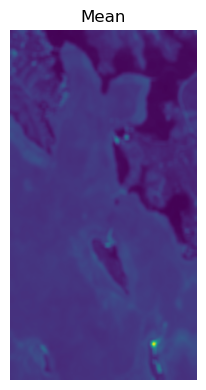

In [32]:
features = patchwise_glcm_feature(
    image_uint8, 
    window_size=7, 
    levels=256
)

# Visualize the features
plt.figure(figsize=(15, 4))
for idx, (name, fmap) in enumerate(features.items()):
    plt.subplot(1, len(features), idx+1)
    plt.imshow(fmap, cmap='viridis')
    plt.title(name.capitalize())
    plt.axis('off')
plt.tight_layout()
plt.show()

In [33]:
image2d

array([[0.0496    , 0.0425    , 0.0389    , ..., 0.1235    , 0.0807    ,
        0.064     ],
       [0.0487    , 0.0421    , 0.0395    , ..., 0.13159999, 0.1074    ,
        0.0719    ],
       [0.0519    , 0.0529    , 0.0485    , ..., 0.1045    , 0.1305    ,
        0.0911    ],
       ...,
       [0.0736    , 0.0716    , 0.0698    , ..., 0.07539999, 0.0755    ,
        0.0766    ],
       [0.0729    , 0.07319999, 0.0705    , ..., 0.0763    , 0.0757    ,
        0.07539999],
       [0.0736    , 0.0741    , 0.0716    , ..., 0.0748    , 0.0751    ,
        0.0751    ]], dtype=float32)

In [34]:
clipped_ds=clipped_ds.squeeze()

In [35]:
for name, arr in features.items():
    clipped_ds[f'glcm_{name}'] = xr.DataArray(
        arr,
        dims=('y', 'x'),
        coords={'y': clipped_ds['y'], 'x': clipped_ds['x']},
        name=f'glcm_{name}'
    )

In [36]:
clipped_ds

<xarray.Dataset> Size: 15MB
Dimensions:      (y: 490, x: 262)
Coordinates:
  * y            (y) float64 4kB -1.055e+06 -1.055e+06 ... -1.06e+06 -1.06e+06
  * x            (x) float64 2kB -3.036e+05 -3.036e+05 ... -3.01e+05 -3.01e+05
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
Data variables: (12/29)
    nir          (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    red          (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    blue         (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    green        (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    emad         (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    smad         (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    ...           ...
    b_g          (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    b_r          (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    mci          (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    ndci         (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    ln_bg        (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    glcm_mean    (y, x) float32 514kB 18.6 19.04 20.17 ... 29.74 29.94 30.02

### Postcard csv

The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data.

Step 1.2. Input the training data to sample geomad data from the postcard

In [37]:
# Define training data
gdf = gpd.read_file("training-data/bootless_bay.geojson")
gdf = gdf.to_crs("EPSG:4326")
# gdf.explore(column="cc_id", legend=True)
clipped_ds

<xarray.Dataset> Size: 15MB
Dimensions:      (y: 490, x: 262)
Coordinates:
  * y            (y) float64 4kB -1.055e+06 -1.055e+06 ... -1.06e+06 -1.06e+06
  * x            (x) float64 2kB -3.036e+05 -3.036e+05 ... -3.01e+05 -3.01e+05
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
Data variables: (12/29)
    nir          (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    red          (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    blue         (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    green        (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    emad         (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    smad         (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    ...           ...
    b_g          (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    b_r          (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    mci          (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    ndci         (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    ln_bg        (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    glcm_mean    (y, x) float32 514kB 18.6 19.04 20.17 ... 29.74 29.94 30.02

In [38]:
clipped_ds = clipped_ds.drop_vars('count')

In [39]:
postcard = clipped_ds#.where(all_masks)
# postcard =clipped_ds.to_array(dim="band")
# First transform the training points to the same CRS as the data
training = gdf.to_crs(postcard.odc.geobox.crs)

In [40]:
print(training.columns)
training=training.drop(columns=['date', 'uuid'])

Index(['uuid', 'cc_id', 'observed', 'date', 'geometry'], dtype='object')


In [41]:
training

,cc_id,observed,geometry
0,4,seagrass,POINT (-302092.206 -1057912.4)
1,4,seagrass,POINT (-302078.83 -1057913.449)
2,4,seagrass,POINT (-302078.478 -1057944.572)
3,4,seagrass,POINT (-302089.39 -1057922.891)
4,4,seagrass,POINT (-302062.638 -1057910.301)
...,...,...,...
815,10,land,POINT (-303113.729 -1059579.147)
816,10,land,POINT (-303119.481 -1059533.436)
817,10,land,POINT (-303119.481 -1059484.296)
818,10,land,POINT (-303136.735 -1059439.728)


In [42]:
training_da = training.assign(x=training.geometry.x, y=training.geometry.y).to_xarray()

In [43]:
training_values = (
    postcard.sel(training_da[["x", "y"]], method="nearest").squeeze().compute().to_pandas()
)
training_values

,nir,red,blue,green,emad,smad,bcmad,nir08,nir09,swir16,...,savi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci,ln_bg,glcm_mean
index,,,,,,,,,,,,,,,,,,,,,
0,0.0602,0.0742,0.0926,0.1005,0.152102,1.803690e-06,0.000034,0.0637,0.0988,0.0605,...,-0.104167,0.097755,0.248447,-0.150544,0.921393,1.247978,0.806971,0.002688,-0.081869,35.809525
1,0.0598,0.0750,0.0989,0.1071,0.161220,2.557254e-06,0.000034,0.0648,0.0689,0.0606,...,-0.112760,0.113539,0.277281,-0.176277,0.923436,1.318667,0.801609,-0.002674,-0.079654,38.059525
2,0.0597,0.0750,0.0949,0.1040,0.161838,2.511090e-06,0.000034,0.0667,0.0682,0.0618,...,-0.113586,0.106913,0.254524,-0.162011,0.912500,1.265333,0.777344,0.011858,-0.091567,38.404762
3,0.0597,0.0752,0.0952,0.1040,0.158307,2.317196e-06,0.000034,0.0662,0.0687,0.0611,...,-0.114900,0.106913,0.259843,-0.160714,0.915385,1.265957,0.790728,0.001991,-0.088411,37.154762
4,0.0580,0.0723,0.0995,0.1074,0.159002,2.570254e-06,0.000034,0.0638,0.0677,0.0595,...,-0.109747,0.118880,0.286998,-0.195326,0.926443,1.376210,0.818054,-0.009776,-0.076403,38.892857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,0.1775,0.0948,0.0561,0.0747,0.111034,1.623791e-06,0.000010,0.2114,0.2068,0.2393,...,0.303709,-0.215817,-0.524204,0.118584,0.751004,0.591772,1.351866,0.161433,-0.286344,21.273809
816,0.2010,0.1046,0.0611,0.0830,0.098046,9.027600e-07,0.000008,0.2511,0.1710,0.2498,...,0.315445,-0.236663,-0.501202,0.115139,0.736145,0.584130,1.382393,0.163200,-0.306329,23.916666
817,0.2130,0.1068,0.0609,0.0865,0.111008,9.993851e-07,0.000008,0.2571,0.1731,0.2613,...,0.332083,-0.248305,-0.502588,0.105018,0.704046,0.570225,1.394892,0.176879,-0.350911,26.702381


/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


In [44]:
# Join the training data with the extracted values and remove unnecessary columns
training_array = pd.concat([training["cc_id"], training_values], axis=1)
# Drop rows where there was no data available
training_array = training_array.dropna()
# Preview our resulting training array
training_array.head()

,cc_id,nir,red,blue,green,emad,smad,bcmad,nir08,nir09,...,savi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci,ln_bg,glcm_mean
0,4,0.0602,0.0742,0.0926,0.1005,0.152102,0.000002,0.000034,0.0637,0.0988,...,-0.104167,0.097755,0.248447,-0.150544,0.921393,1.247978,0.806971,0.002688,-0.081869,35.809525
1,4,0.0598,0.0750,0.0989,0.1071,0.161220,0.000003,0.000034,0.0648,0.0689,...,-0.112760,0.113539,0.277281,-0.176277,0.923436,1.318667,0.801609,-0.002674,-0.079654,38.059525
2,4,0.0597,0.0750,0.0949,0.1040,0.161838,0.000003,0.000034,0.0667,0.0682,...,-0.113586,0.106913,0.254524,-0.162011,0.912500,1.265333,0.777344,0.011858,-0.091567,38.404762
3,4,0.0597,0.0752,0.0952,0.1040,0.158307,0.000002,0.000034,0.0662,0.0687,...,-0.114900,0.106913,0.259843,-0.160714,0.915385,1.265957,0.790728,0.001991,-0.088411,37.154762
4,4,0.0580,0.0723,0.0995,0.1074,0.159002,0.000003,0.000034,0.0638,0.0677,...,-0.109747,0.118880,0.286998,-0.195326,0.926443,1.376210,0.818054,-0.009776,-0.076403,38.892857


### Notebook 2 - Train Random Forest Machine Learning (ML) Model

Combine the csv geodataframes from notebook 1 into a single csv to train the machine learning model

Step 2.1. Concatenating all postcard dataframes

In [45]:
postcard_df = training_array
postcard_df.columns

Index(['cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad',
       'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1', 'rededge2',
       'rededge3', 'y', 'x', 'spatial_ref', 'time', 'cai', 'ndvi', 'evi',
       'savi', 'ndwi', 'mndwi', 'ndti', 'b_g', 'b_r', 'mci', 'ndci', 'ln_bg',
       'glcm_mean'],
      dtype='object')

In [46]:
# postcard_df.columns
# postcard_df = postcard_df.drop(columns=["spatial_ref", "time", "field_1", "y", "x"])
# postcard_df = postcard_df.drop(columns=["field_1"])
postcard_df = postcard_df.drop(columns=["y", "x", "spatial_ref", "time"])
# postcard_df = postcard_df.drop(columns=["time"])
postcard_df

,cc_id,nir,red,blue,green,emad,smad,bcmad,nir08,nir09,...,savi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci,ln_bg,glcm_mean
0,4,0.0602,0.0742,0.0926,0.1005,0.152102,1.803690e-06,0.000034,0.0637,0.0988,...,-0.104167,0.097755,0.248447,-0.150544,0.921393,1.247978,0.806971,0.002688,-0.081869,35.809525
1,4,0.0598,0.0750,0.0989,0.1071,0.161220,2.557254e-06,0.000034,0.0648,0.0689,...,-0.112760,0.113539,0.277281,-0.176277,0.923436,1.318667,0.801609,-0.002674,-0.079654,38.059525
2,4,0.0597,0.0750,0.0949,0.1040,0.161838,2.511090e-06,0.000034,0.0667,0.0682,...,-0.113586,0.106913,0.254524,-0.162011,0.912500,1.265333,0.777344,0.011858,-0.091567,38.404762
3,4,0.0597,0.0752,0.0952,0.1040,0.158307,2.317196e-06,0.000034,0.0662,0.0687,...,-0.114900,0.106913,0.259843,-0.160714,0.915385,1.265957,0.790728,0.001991,-0.088411,37.154762
4,4,0.0580,0.0723,0.0995,0.1074,0.159002,2.570254e-06,0.000034,0.0638,0.0677,...,-0.109747,0.118880,0.286998,-0.195326,0.926443,1.376210,0.818054,-0.009776,-0.076403,38.892857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,10,0.1775,0.0948,0.0561,0.0747,0.111034,1.623791e-06,0.000010,0.2114,0.2068,...,0.303709,-0.215817,-0.524204,0.118584,0.751004,0.591772,1.351866,0.161433,-0.286344,21.273809
816,10,0.2010,0.1046,0.0611,0.0830,0.098046,9.027600e-07,0.000008,0.2511,0.1710,...,0.315445,-0.236663,-0.501202,0.115139,0.736145,0.584130,1.382393,0.163200,-0.306329,23.916666
817,10,0.2130,0.1068,0.0609,0.0865,0.111008,9.993851e-07,0.000008,0.2571,0.1731,...,0.332083,-0.248305,-0.502588,0.105018,0.704046,0.570225,1.394892,0.176879,-0.350911,26.702381
818,10,0.1982,0.1157,0.0670,0.0885,0.087393,5.472064e-07,0.000006,0.2527,0.1912,...,0.262823,-0.219185,-0.492982,0.133203,0.757062,0.579084,1.256020,0.153931,-0.278310,26.011906


In [47]:
postcard_df.columns

Index(['cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad',
       'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1', 'rededge2',
       'rededge3', 'cai', 'ndvi', 'evi', 'savi', 'ndwi', 'mndwi', 'ndti',
       'b_g', 'b_r', 'mci', 'ndci', 'ln_bg', 'glcm_mean'],
      dtype='object')

In [48]:
len(postcard_df.columns)

29

In [49]:
postcard_df.to_csv("training-data/" + str(version) + "35_params_tdata_04072025.csv")

In [50]:
joined_df = pd.read_csv("training-data/" + str(version) + "35_params_tdata_04072025.csv")

joined_df = joined_df.drop(columns=["Unnamed: 0"])
joined_df.columns

Index(['cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad',
       'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1', 'rededge2',
       'rededge3', 'cai', 'ndvi', 'evi', 'savi', 'ndwi', 'mndwi', 'ndti',
       'b_g', 'b_r', 'mci', 'ndci', 'ln_bg', 'glcm_mean'],
      dtype='object')

Step 2.2. Train the ML model

In [51]:
# The classes are the first column
classes = np.array(postcard_df)[:, 0]

# The observation data is everything after the second column
observations = np.array(postcard_df)[:, 1:]

# Create a model...
classifier = RandomForestClassifier()

# ...and fit it to the data
model = classifier.fit(observations, classes)

In [52]:
# Dynamically create the filename with f-string
file_path = f"models/{version}-test.model"

# Save the model
joblib.dump(model, file_path)

['models/nm-bootless-04-07-2025-test.model']

In [53]:
postcard_params = postcard_df.columns[1:]
print(postcard_params)

Index(['nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad', 'nir08',
       'nir09', 'swir16', 'swir22', 'coastal', 'rededge1', 'rededge2',
       'rededge3', 'cai', 'ndvi', 'evi', 'savi', 'ndwi', 'mndwi', 'ndti',
       'b_g', 'b_r', 'mci', 'ndci', 'ln_bg', 'glcm_mean'],
      dtype='object')


In [54]:
importances = classifier.feature_importances_

# Create the DataFrame
data = {
    'param': postcard_params,  # Use the list directly
    'importance': importances,  # Use the list directly
}
importance_df = pd.DataFrame(data)

importance_df["%"] = (importance_df["importance"]*100)

sorted_df = importance_df.sort_values(by='importance', ascending=False)
sorted_df.to_csv(f"{version}_importance_df.csv")

In [55]:
sorted_df

,param,importance,%
22,b_g,0.116434,11.643448
26,ln_bg,0.093425,9.342504
3,green,0.082822,8.282165
27,glcm_mean,0.069066,6.906625
24,mci,0.062001,6.200054
2,blue,0.053874,5.387424
1,red,0.051848,5.184827
16,ndvi,0.044521,4.452136
12,rededge1,0.043483,4.348298
18,savi,0.040051,4.005065


In [56]:
postcard


<xarray.Dataset> Size: 14MB
Dimensions:      (y: 490, x: 262)
Coordinates:
  * y            (y) float64 4kB -1.055e+06 -1.055e+06 ... -1.06e+06 -1.06e+06
  * x            (x) float64 2kB -3.036e+05 -3.036e+05 ... -3.01e+05 -3.01e+05
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
Data variables: (12/28)
    nir          (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    red          (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    blue         (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    green        (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    emad         (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    smad         (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    ...           ...
    b_g          (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    b_r          (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    mci          (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    ndci         (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    ln_bg        (y, x) float32 514kB dask.array<chunksize=(490, 262), meta=np.ndarray>
    glcm_mean    (y, x) float32 514kB 18.6 19.04 20.17 ... 29.74 29.94 30.02

In [57]:
# Convert to a stacked array of observations
# stacked_arrays = stacked_arrays.squeeze()
stacked_arrays = postcard.squeeze()#.stack(dims=["y", "x"])#.transpose()
stacked_arrays = stacked_arrays.to_dataarray()

In [58]:
stacked_arrays

<xarray.DataArray (variable: 28, y: 490, x: 262)> Size: 14MB
dask.array<stack, shape=(28, 490, 262), dtype=float32, chunksize=(1, 490, 262), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 4kB -1.055e+06 -1.055e+06 ... -1.06e+06 -1.06e+06
  * x            (x) float64 2kB -3.036e+05 -3.036e+05 ... -3.01e+05 -3.01e+05
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
  * variable     (variable) object 224B 'nir' 'red' ... 'ln_bg' 'glcm_mean'

In [59]:
# stacked_arrays_2d

In [60]:
stacked_arrays_2d = stacked_arrays.stack(new_dim=("y", "x")) 

In [61]:
reordered_data_array = stacked_arrays_2d.transpose('new_dim', 'variable')

In [62]:
# stacked_arrays = stacked_arrays.reshape(-1, 26)
stacked_arrays_2d.shape


(28, 128380)

In [63]:
stacked_arrays_2d

<xarray.DataArray (variable: 28, new_dim: 128380)> Size: 14MB
dask.array<reshape, shape=(28, 128380), dtype=float32, chunksize=(1, 128380), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
  * variable     (variable) object 224B 'nir' 'red' ... 'ln_bg' 'glcm_mean'
  * new_dim      (new_dim) object 1MB MultiIndex
  * y            (new_dim) float64 1MB -1.055e+06 -1.055e+06 ... -1.06e+06
  * x            (new_dim) float64 1MB -3.036e+05 -3.036e+05 ... -3.01e+05

In [64]:
# Convert to a stacked array of observations
# stacked_arrays_2d = stacked_arrays_2d.to_array().stack(dims=["y", "x"])

# Replace any infinities with NaN
stacked_arrays_2d = stacked_arrays_2d.where(stacked_arrays_2d != float("inf"))
stacked_arrays_2d = stacked_arrays_2d.where(stacked_arrays_2d != float("-inf"))

# Replace any NaN values with 0
df = stacked_arrays_2d.squeeze().fillna(0).transpose().to_pandas()

# Remove the all-zero rows
zero_mask = (df == 0).all(axis=1)  # Creates a boolean Series
non_zero_df = df.loc[~zero_mask]  # Filters out all-zero rows

# Create a new array to hold the predictions
full_pred = pd.Series(np.nan, index=df.index)

reordered_data_array = stacked_arrays_2d.transpose('new_dim', 'variable')

In [65]:
# Predict the classes
predicted = model.predict(reordered_data_array)

In [66]:

# Reshape back to the original 2D array
reordered_data_array = predicted.reshape(len(postcard.y), len(postcard.x))

# Convert to an xarray again, because it's easier to work with
predicted_da = xr.DataArray(
    reordered_data_array, coords={"y": postcard.y, "x": postcard.x}, dims=["y", "x"]
)

In [67]:
print(predicted_da.dtype)  # Check the dtype of your DataArray
predicted_da = predicted_da.astype('float32')  # Convert to float32

# Check for NaN values
if np.isnan(predicted_da).any():
    print("NaN values found in the data")
    # Handle NaN values, e.g. by filling them
    predicted_da = predicted_da.fillna(0)  # Replace NaN with 0 or appropriate value

float64


In [68]:
predicted_da

<xarray.DataArray (y: 490, x: 262)> Size: 514kB
array([[10., 10., 10., ...,  7.,  7.,  7.],
       [10., 10., 10., ...,  7.,  7., 10.],
       [10., 10., 10., ...,  7.,  7., 10.],
       ...,
       [ 8.,  8.,  8., ...,  8.,  8.,  8.],
       [ 8.,  8.,  8., ...,  8.,  8.,  8.],
       [ 8.,  8.,  8., ...,  8.,  8.,  8.]], dtype=float32)
Coordinates:
  * y        (y) float64 4kB -1.055e+06 -1.055e+06 ... -1.06e+06 -1.06e+06
  * x        (x) float64 2kB -3.036e+05 -3.036e+05 ... -3.01e+05 -3.01e+05

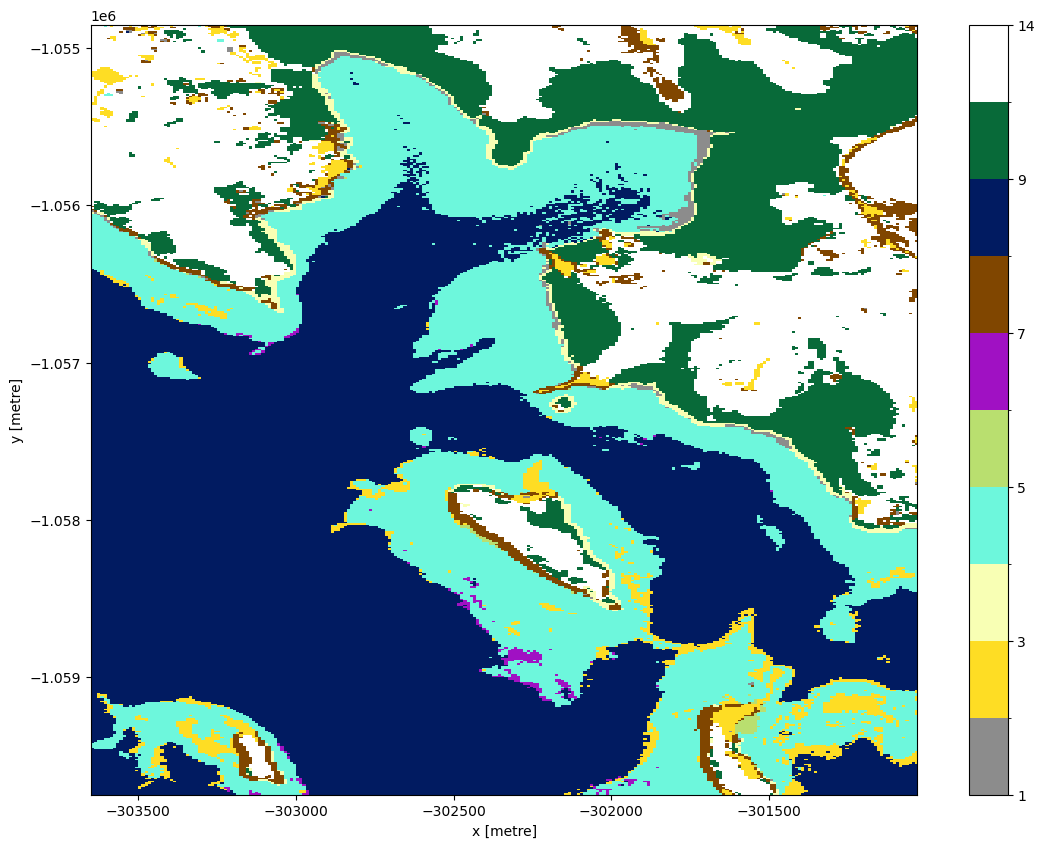

In [69]:
from matplotlib import colors

classes = [
    [1, "sediment", "#8c8c8c"],
    [2, "sand", "#fedd24"],
    [3, "rubble", "#f8ffb4"],
    [4, "seagrass", "#6df7dc"],
    [5, "seaweed", "#b9df6f"],
    [6, "coral", "#a011c3"],
    [7, "rock", "#804600"],
    [8, "deeps", "#011b61"],
    [9, "mangrove", "#086a39"],
    [10, "land", "#ffffff"],
]

values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [14]
norm = colors.BoundaryNorm(bounds, c_map.N)

predicted_da.plot.imshow(cmap=c_map, norm=norm, size=10)

In [70]:
predicted_da.odc.explore()

In [71]:
# issue where not all masks are being included - only land but not surf / also strange effect on side
predicted_da = predicted_da.where(all_masks)

In [72]:
predicted_da.odc.explore(cmap=c_map)

In [73]:
# issue where not all masks are being included - only land but not surf / also strange effect on side
predicted_da = predicted_da.where(bg < 0.2)
predicted_da.odc.explore(cmap=c_map)

In [74]:
predicted_da.odc.write_cog(f"{version}.tiff", overwrite=True)

PosixPath('nm-bootless-04-07-2025.tiff')